In [1]:
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from keras.models import Sequential
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")

data = pd.read_csv("demand_inventory.csv")
print(data.head())

   Unnamed: 0        Date Product_ID  Demand  Inventory
0           0  2023-06-01         P1      51       5500
1           1  2023-06-02         P1     141       5449
2           2  2023-06-03         P1     172       5308
3           3  2023-06-04         P1      91       5136
4           4  2023-06-05         P1     198       5045


In [2]:
data = data.drop(columns=['Unnamed: 0'])

In [3]:
#visualize the demand over time:

fig_demand = px.line(data, x='Date', y='Demand', title='Demand Over Time')
fig_demand.show()

In [4]:
#visualize the inventory over time:

fig_inventory = px.line(data, x='Date', y='Inventory', title='Inventory Over Time')
fig_inventory.show()

Demand Forecasting:
forecast the demand using SARIMA.
first calculate the value of p and q using ACF and PACF plots:

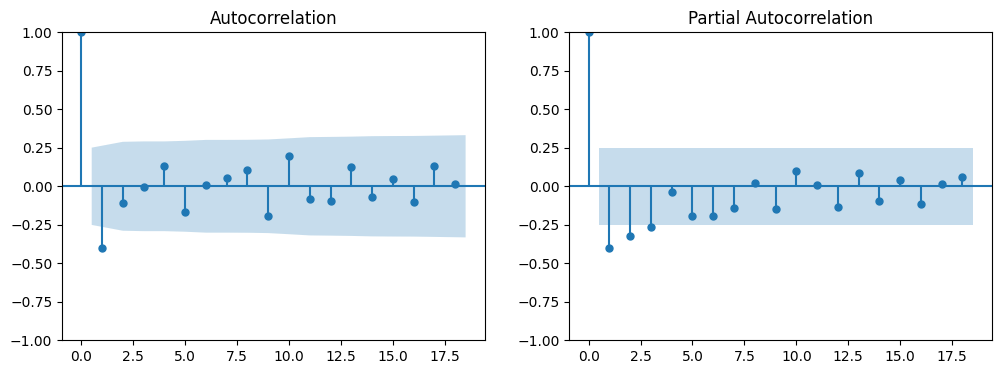

In [5]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
time_series = data.set_index('Date')['Demand']

differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [6]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2) #2 because the data contains a time period of 2 months only
model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

2023-08-02    117
2023-08-03    116
2023-08-04    130
2023-08-05    114
2023-08-06    128
2023-08-07    115
2023-08-08    129
2023-08-09    115
2023-08-10    129
2023-08-11    115
Freq: D, Name: predicted_mean, dtype: int64


Inventory Optimization:

optimize inventory according to the forecast demand for the next ten days:

In [7]:
# Create date indices for the future predictions
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')

# Create a pandas Series with the predicted values and date indices
forecasted_demand = pd.Series(predictions, index=future_dates)

# Initial inventory level
initial_inventory = 5500

# Lead time (number of days it takes to replenish inventory)
lead_time = 1 # it Varies for every business, 1 is an example

# Service level (probability of not stocking out)
service_level = 0.95 # it Varies for every business, 0.95 is an example

# Calculate the optimal order quantity using the Newsvendor formula
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)

# Calculate the reorder point
reorder_point = forecasted_demand.mean() * lead_time + z

# Calculate the optimal safety stock
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

# Calculate the total cost (holding cost + stockout cost)
holding_cost = 0.1  # it Varies for every business, 0.1 is an example
stockout_cost = 10  # # it Varies for every business, 10 is an example
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)

# Calculate the total cost
total_cost = total_holding_cost + total_stockout_cost

print("Optimal Order Quantity:", order_quantity)
print("Reorder Point:", reorder_point)
print("Safety Stock:", safety_stock)
print("Total Cost:", total_cost)

Optimal Order Quantity: 236
Reorder Point: 235.25
Safety Stock: 114.45
Total Cost: 561.8000000000001


Summary:

Optimal Order Quantity: 236 - The optimal order quantity is the amount of merchandise that should be ordered from suppliers when the inventory level exceeds a given threshold. In this situation, the optimal order quantity of 236 units has been determined.

Reorder Point: 235.25 - The reorder point is the inventory level at which a fresh order should be made to refill supplies before they run out. In this scenario, a reorder point of 235.25 units has been determined, indicating that when inventory hits or falls below this level, an order should be issued to refill stock.

Safety Stock: 114.45 - This is the extra inventory maintained on hand to allow for fluctuations in demand and supply. It serves as a buffer against unforeseen fluctuations in demand or lead time. In this scenario, a safety stock of 114.45 units has been estimated to guarantee that there is adequate inventory to meet any swings in demand or lead time.

Total Cost: 561.80 - This figure shows the entire cost of inventory management. The total cost has been assessed to be roughly 561.80 units based on the order quantity, reorder point, safety stock, and associated charges.

You can make educated judgments about how much inventory to purchase and when to place orders to maintain a seamless supply chain and customer satisfaction while keeping costs low.